# First try - coupling between two oscillators

[ 2.43453711 -2.43453711]
[[ 0.          2.43453711]
 [-2.43453711  0.        ]]
entry vs new
[3.2 1.5]
[-0.43253711  4.42353711]


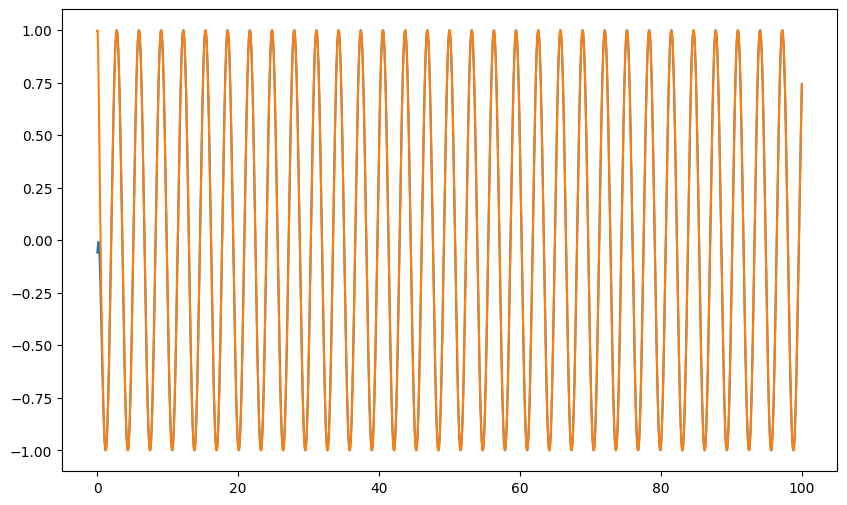

In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

def kuramoto_oscillators(theta, t, omega, K, N):
    dtheta_dt = omega - (K/N) * np.sum(np.sin(np.subtract.outer(theta, theta)), axis=1)
    return dtheta_dt

N = 2  # Number of oscillators
K = 4.91  # Increased coupling strength to make the coupling effect more visible
T = 100.0  # Total time
dt = 0.01  # Time step
times = np.arange(0, T+dt, dt)


theta0 = np.random.uniform(0, 2*np.pi, N) #initial phases
omega = np.array([np.random.normal(1,0.03) for i in range(N)]) #frequencies

theta0 = np.array([3.2,1.5])
omega = np.array([2.002,1.989])

thetas = odeint(kuramoto_oscillators, theta0, times, args=(omega, K, N))


print((K/N) * np.sum(np.sin(np.subtract.outer(theta0, theta0)), axis=1))
print((K/N) * np.sin(np.subtract.outer(theta0, theta0)))
print("entry vs new")
print(theta0)
print(omega - (K/N) * np.sum(np.sin(np.subtract.outer(theta0, theta0)), axis=1))

plt.figure(figsize=(10, 6))
for i in range(N):
    plt.plot(times, np.sin(thetas[:, i]), label=f'Oscillator {i+1}')
plt.show()

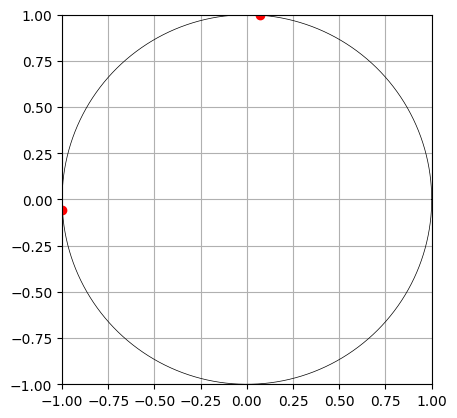

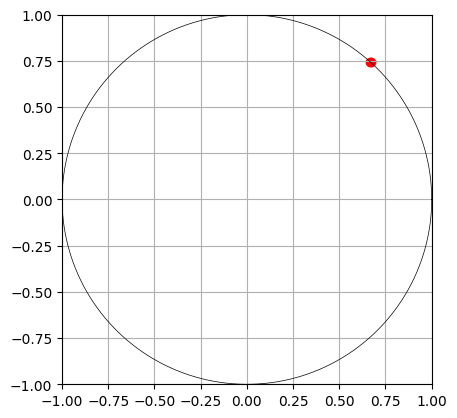

In [229]:
phi_circ = np.linspace(0,2*np.pi,2000)



figure, axes = plt.subplots()
axes.set_aspect( 1 )
axes.set_xlim(-1,1)
axes.set_ylim(-1,1)
plt.grid()
plt.plot(np.cos(phi_circ),np.sin(phi_circ),c="black",linewidth=0.5)
for i in range(N):
    plt.scatter(np.cos(thetas[0,i]), np.sin(thetas[0,i]), c="red")
    
    
plt.show()

figure, axes = plt.subplots()
axes.set_aspect( 1 )
axes.set_xlim(-1,1)
axes.set_ylim(-1,1)
plt.grid()
plt.plot(np.cos(phi_circ),np.sin(phi_circ),c="black",linewidth=0.5)
for i in range(N):
    plt.scatter(np.cos(thetas[-1,i]), np.sin(thetas[-1,i]), c="red")
    
plt.show()

# Multiple oscillators - coupling with randomly selected 4 neighbors

In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

def kuramoto_oscillators(theta, t, omega, K, N):
    neighboring_phases = np.random.choice(
        np.subtract.outer(thetas[0,:], thetas[0,:]).flatten()
        , 4, replace=False)
        
    dtheta_dt = omega - (K/N) * np.sum(np.sin(neighboring_phases), axis=0)
    return dtheta_dt

N = 40  # Number of oscillators
K = 5  # Increased coupling strength to make the coupling effect more visible
T = 5000.0  # Total time
dt = 0.01  # Time step
times = np.arange(0, T+dt, dt)


theta0 = np.random.uniform(0, 2*np.pi, N) #initial phases
omega = np.ones(N)+np.random.uniform(0,0.3,N) #frequencies

thetas = odeint(kuramoto_oscillators, theta0, times, args=(omega, K, N))

plt.figure(figsize=(10, 6))
for i in range(N):
    plt.plot(times, np.sin(thetas[:, i]), label=f'Oscillator {i+1}')
plt.show()

phi_circ = np.linspace(0,2*np.pi,2000)


"""
figure, axes = plt.subplots()
axes.set_aspect( 1 )
axes.set_xlim(-1,1)
axes.set_ylim(-1,1)
plt.grid()
plt.plot(np.cos(phi_circ),np.sin(phi_circ),c="black",linewidth=0.5)
for i in range(N):
    plt.scatter(np.cos(thetas[0,i]), np.sin(thetas[0,i]), c="red")
    
    
plt.show()
"""

figure, axes = plt.subplots()
axes.set_aspect( 1 )
axes.set_xlim(-1,1)
axes.set_ylim(-1,1)
plt.grid()
plt.plot(np.cos(phi_circ),np.sin(phi_circ),c="black",linewidth=0.5)
for i in range(N):
    plt.scatter(np.cos(thetas[-1,i]), np.sin(thetas[-1,i]), c="red")
    
plt.show()

NameError: name 'thetas' is not defined

# Functions and imports
*Of course it can be done easily with plain python or numpy, but having specialized library is most often better and more legible choice*

- in the future, optimally, pytorch methods and objects should be used, but that will do after introductory models will prove to be useful and trainable

Definitions

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.integrate import odeint
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
import colorsys
import os
import imageio
import re

def graph_weighted_plot(ax, graph):
    """
    draw graph with edge weights (formatted to two relevant digits) and frequency values on a specified Matplotlib axis (ax)
    returns nothing
    """
    pos = dict((n, n) for n in graph.nodes())
    esmall = [(u, v) for (u, v, d) in graph.edges(data=True)]

    # Nodes
    nx.draw_networkx_nodes(graph, pos, node_size=700, ax=ax)

    # Edges
    nx.draw_networkx_edges(
        graph, pos, edgelist=esmall, width=6, alpha=0.5, edge_color="b", style="dashed", ax=ax
    )

    # Edge labels with weights formatted to two relevant digits
    edge_labels_raw = nx.get_edge_attributes(graph, "weight")
    edge_labels = {edge: f"{weight:.2f}" for edge, weight in edge_labels_raw.items()}
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels, ax=ax)

    # Node labels with frequency values
    node_labels = {node: f"{graph.nodes[node]['frequency']:.2f}" for node in graph.nodes()}
    nx.draw_networkx_labels(graph, pos, labels=node_labels, font_size=8, font_family="sans-serif", ax=ax)
    return ax

def adjust_values_to_range(matrix, lower_bound, upper_bound):
    """
    Adjust the values in the matrix to ensure they fall within the specified range.
    The lowest value in the matrix will be set to the lower_bound.
    """
    # Calculate the shift needed to set the lowest value to the lower_bound
    shift = lower_bound - np.min(matrix)
    matrix += shift
    
    # Ensure all values fall within the lower_bound to upper_bound range
    range_width = upper_bound - lower_bound
    matrix = (matrix - lower_bound) % range_width + lower_bound
    return matrix

def graph_pixel_plot(ax, graph, g_len, g_wid, draw_value="phase"):
    """
    Draw node values for square lattice graph with values ranging from -π to 0 in blue and 0 to π in orange.
    returns plot (pyplot figure object)

    g_len - maximal graph length
    g_wid - maximal graph width
    """    
    plot_matrix = np.zeros([g_wid, g_len])
    points = graph.nodes
    for i in points:
        plot_matrix[i[1]][i[0]] = points[tuple(i)][draw_value]

    plot_matrix = adjust_values_to_range(plot_matrix, -np.pi, np.pi)

    ax.set_title("Pixel plot of network")


    norm = mcolors.TwoSlopeNorm(vmin=-np.pi, vcenter=0, vmax=np.pi)
    img = ax.imshow(plot_matrix, cmap='coolwarm', norm=norm, interpolation='nearest')
    cbar = plt.colorbar(img, ax=ax, fraction=0.046, pad=0.04, label=f'{draw_value} value')


    if draw_value=="phase":
        #cbar.set_ticks([-np.pi, 0, np.pi])
        #cbar.set_ticklabels([r'$-\pi$', r'0', r'$\pi$'])
        cbar.set_ticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
        cbar.set_ticklabels([r'$-\pi$', r'$-\frac{\pi}{2}$', r'$0$', r'$\frac{\pi}{2}$', r'$\pi$'])

    return ax

def draw_phase_correlation(ax, graph, rotate=False):
    """
    Draw a scatter plot with phase values of nodes on a unit circle.
    returns pyplot (figure, axis) tuple

    if rotate==True plot will be rotated so that "center of mass" of phases always points upwards
    """
    phase_array = []

    for node in graph.nodes():
        phase_array.append(graph.nodes[node]["phase"])
    x = np.cos(phase_array)
    y = np.sin(phase_array)


    #calcularting "COM"
    center_of_mass = np.array([np.sum(x),np.sum(y)])/len(phase_array)

    rotation_matrix=np.array([[1,0],[0,1]])
    if rotate:
        angle_to_com = np.arctan2(center_of_mass[1], center_of_mass[0])
        angle_to_rotate = -angle_to_com + np.pi/2
        rotation_matrix = np.array([[np.cos(angle_to_rotate), -np.sin(angle_to_rotate)], 
                                    [np.sin(angle_to_rotate), np.cos(angle_to_rotate)]])
        
    # Rotate all points
    for i in range(len(x)):
        [x[i], y[i]] = np.dot(rotation_matrix, np.array([x[i], y[i]]))
    
    # Recalculate COM after rotation
    center_of_mass = np.array([np.sum(x),np.sum(y)])/len(phase_array)

    ax.set_aspect('equal')

    ax.set_title(r"Phase Plot for All Nodes")
    ax.scatter(x, y, c="r")


    plt.scatter(*center_of_mass,c="blue")
    plt.plot([0, center_of_mass[0]], [0, center_of_mass[1]], '-', linewidth=0.8, c="b")

    #plotting lines and circumference
    phi_circ = np.linspace(0, 2*np.pi, 2000)
    ax.plot(np.cos(phi_circ), np.sin(phi_circ), c="black", linewidth=0.5)
    ax.set_xlim([-1.1, 1.1])
    ax.set_ylim([-1.1, 1.1])

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])   
    angle_diff_deg = 30
    for angle in np.linspace(0, 2*np.pi, 12, endpoint=False):
        ax.plot([0, np.cos(angle)], [0, np.sin(angle)], 'k--', linewidth=0.5)
    
    return ax

def add_neighboring_nodes(graph, lenx, leny):
    """
    add square lattice of nearest neighbor connected nodes
    lenx - integer length of graph
    leny - integer width of graph
    """
    points = [(x, y) for x in range(lenx) for y in range(leny)]
    for point in points:
        graph.add_node(point)
        x, y = point
        
        neighbors = [(x-1, y), (x+1, y), (x, y-1), (x, y+1)]
        for ix, iy in neighbors:
            if (ix, iy) in points:
                graph.add_edge(point, (ix, iy))
    return

nx.Graph.add_neighboring_nodes = add_neighboring_nodes


def graph_kuramoto_oscillators(theta, t, omega, K, h, psi, N, coupled_theta):
    """
    Function designed to be integrated with odeint method. Mind that all arrays should be ordered in the same way.

    theta - phase of all oscillators (numpy array of all phases)
    t - time (numpy array)
    omega - angular frequencies of all oscilators (numpy array of all frequencies)
    K - weights of all oscillator couplings (numpy array of numpy arrays of coupling weights)
    N - number of couplings
    coupled_theta - phases of coupled oscillators (numpy array of numpy arrays of coupling phases)
    """
    dtheta_dt = np.zeros_like(theta)
    for i in range(N):
        if -1 in coupled_theta[i]:  # Handle independent nodes
            dtheta_dt[i] = omega[i]
        else:
            coupled_values = theta[coupled_theta[i]]
            sin_diffs = np.sin(theta[i] - coupled_values)
            sin_external = np.sin(theta[i] - psi[i])
            """
            kuramoto model
            """
            #sin_diffs = np.sin(coupled_values - theta[i])
            #dtheta_dt[i] = omega[i] + np.sum(K[i] * sin_diffs) / N
            """
            spin model (Wang 2024)
            """
            dtheta_dt[i] = np.sum((K[i] * sin_diffs) - (h[i]*sin_external)) / N
    return dtheta_dt

#tweaked for spin model
def integrate_graph(graph, times, independent_nodes=[0,1], full_output = False):
    """
    integrates kuramoto model explicitely using scipy.integrate.odeint method

    independent_nodes contains tuples with node indeces (int, int). those nodes have no pairing and are unaffected by other oscillators (their phase differences are constant)
    """
    theta0 = np.array([node[1]['phase'] for node in graph.nodes(data=True)])
    omega = np.array([node[1]['frequency'] for node in graph.nodes(data=True)])
    h = np.array([node[1]['bias'] for node in graph.nodes(data=True)])
    psi = np.array([node[1]['bias_phase'] for node in graph.nodes(data=True)])


    #treatment of edge data
    #first three lines are may be not important, but I won't be judging it yet
    K = [[edge[2] for edge in graph.edges(node, data="weight")] for node in graph.nodes]
    # maybe I should ask Luciano if this N should represent size of network or number of connections
    N = graph.number_of_nodes()
    # padding necessary for numpy methods to work
    max_length = max([len(sublist) for sublist in K])
    K = np.zeros((N, max_length))
    coupled_theta = np.zeros((N, max_length)).astype(int)

    #requires theta0 to be different (randomized if possible)
    independent_indices = [np.where(theta0 == graph.nodes[node]['phase'])[0][0] for node in independent_nodes]
    
    for i, node in enumerate(graph.nodes()):
        for j, neighbor in enumerate(graph.neighbors(node)):
            K[i, j] = graph[node][neighbor]['weight']
            neighbor_index = int(np.where(theta0==graph.nodes[neighbor]['phase'])[0][0])
            coupled_theta[i, j] = neighbor_index if i not in independent_indices else i  # this should return coupling to self which indicates no coupling at all
    

    thetas, output = odeint(graph_kuramoto_oscillators, theta0, times, args=(omega, K, h, psi, N, coupled_theta), full_output=1)
    return (thetas, output) if full_output else thetas

def update_graph_nodes(graph, phase_list, copy=True):
    if copy:
        new_graph = graph.copy()
        phase_dict = {node: phase for node, phase in zip(graph.nodes, phase_list)}
        nx.set_node_attributes(new_graph,phase_dict,"phase")
        return new_graph
    else:
        phase_dict = {node: phase for node, phase in zip(graph.nodes, phase_list)}
        nx.set_node_attributes(graph,phase_dict,"phase")

def sort_key_func(file):
    """
    Custom sort function to extract and return the integer from the filename.
    If the filename does not contain an integer, it returns -1 so that file gets sorted to the beginning.
    """
    numbers = re.findall(r'\d+', file)
    if numbers:
        return int(numbers[0])
    return -1

def create_video(image_dir, output_file, fps=2):
    # List all .png files and sort them by the integer in their filenames
    image_files = [os.path.join(image_dir, file) for file in os.listdir(image_dir) if file.endswith('.png')]
    image_files.sort(key=sort_key_func)
    
    # Initialize the video writer
    writer = imageio.get_writer(output_file, fps=fps)
    
    # Read each image and append it to the video
    for image_file in image_files:
        image = imageio.imread(image_file)
        writer.append_data(image)
    
    # Finalize the video
    writer.close()
    print(f"Video saved as {output_file}")


def clear_directory(directory):
    # Check if the directory exists
    if os.path.exists(directory):
        # Remove all files and subdirectories in the directory
        for filename in os.listdir(directory):
            file_path = os.path.join(directory, filename)
            try:
                if os.path.isfile(file_path) or os.path.islink(file_path):
                    os.unlink(file_path)
                elif os.path.isdir(file_path):
                    shutil.rmtree(file_path)
            except Exception as e:
                print(f'Failed to delete {file_path}. Reason: {e}')
    else:
        print(f"The directory {directory} does not exist.")

def generate_evolution_and_animation(network, times, number_of_frames,fps=2,filename="animation_pixel.gif", independent_nodes=[], draw_pixel=True, rotate=True):
    # Directories to save the figures
    pixel_dir = 'animation_pixel_phase'

    # Create directories if they don't exist
    os.makedirs(pixel_dir, exist_ok=True)

    clear_directory('animation_pixel_phase')

    for i, time in enumerate(times):
        if i % int(len(times)/number_of_frames) == 0:  # Every 10 units of time, since dt=0.01
            thetas, _ = integrate_graph(network, times[:i+1], independent_nodes=independent_nodes, full_output=1)
            new_network = update_graph_nodes(network, thetas[-1])
            
            # Generate and save the pixel plot
            if draw_pixel:
                fig, axs = plt.subplots(2, 1, figsize=(7, 14))
                graph_pixel_plot(axs[0], new_network, g_len, g_wid)
                draw_phase_correlation(axs[1], new_network, rotate=rotate)
            else:
                fig, axs = plt.subplots(figsize=(7, 7))
                draw_phase_correlation(axs, new_network, rotate=rotate)
            pixel_filename = os.path.join(pixel_dir, f'pixel_phase_plot_{i}.png')
            fig.savefig(pixel_filename)
            plt.close(fig)  # Close the figure to free memory
            del thetas
            del new_network
            del fig, axs
    
    create_video('animation_pixel_phase', 'animation.gif', fps=fps)
    return

def randomize_node_phases(graph):
    phase_list = [np.random.uniform(-np.pi, np.pi) for _ in graph.nodes]
    phase_dict = {node: phase for node, phase in zip(graph.nodes, phase_list)}
    nx.set_node_attributes(graph,phase_dict,"phase")
    return graph

def update_weights_simple(graph, learning_rate, gradient):
    for i, (u, v, data) in enumerate(graph.edges(data=True)):      
        data['weight'] -= learning_rate * gradient[i]

def update_biases_simple(graph, learning_rate, bias_gradient, bias_phase_gradient):
    for i, (n, data) in enumerate(graph.nodes(data=True)):
        data['bias'] -= learning_rate * bias_gradient[i]
        data['bias_phase'] -= learning_rate * bias_phase_gradient[i]

def give_input(graph, input_nodes, input_values):
    for i, node in enumerate(input_nodes):
        graph.nodes[node]["phase"] = input_values[i]


#this might not be the best way to nudge, size of change is largely dependent on how far from target we stand.
def nudge_output(graph, output_nodes, target, nudge_size):
    for i, node in enumerate(output_nodes):
        current_phase = graph.nodes[node]['phase']
        new_phase = (1-nudge_size)*current_phase + nudge_size * (target[i])
        graph.nodes[node]['phase'] = new_phase


Setting up network

In [135]:
G = nx.Graph()
g_len = 2
g_wid = 2

nx.Graph.add_neighboring_nodes(G,g_len,g_wid)

#making dictionary of weights
weight_list = np.around([np.random.normal(0., 1.) for _ in G.edges], decimals=2)
weight_dict = {edge: weight for edge, weight in zip(G.edges, weight_list)}

phase_list = np.around([np.random.normal(0., 2*np.pi) for _ in G.edges], decimals=2) 
phase_dict = {node: phase for node, phase in zip(G.nodes, phase_list)}

frequency_list = np.around([ 1 + np.random.normal(0., 0.3) for _ in G.edges], decimals=3) 
frequency_dict = {node: freq for node, freq in zip(G.nodes, frequency_list)}

nx.set_edge_attributes(G,weight_dict,"weight")
nx.set_node_attributes(G,phase_dict,"phase")
nx.set_node_attributes(G,frequency_dict,"frequency")

Drawing

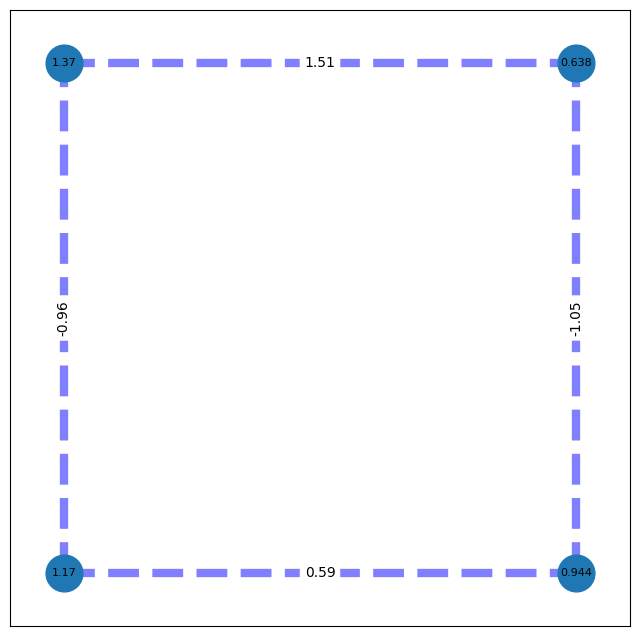

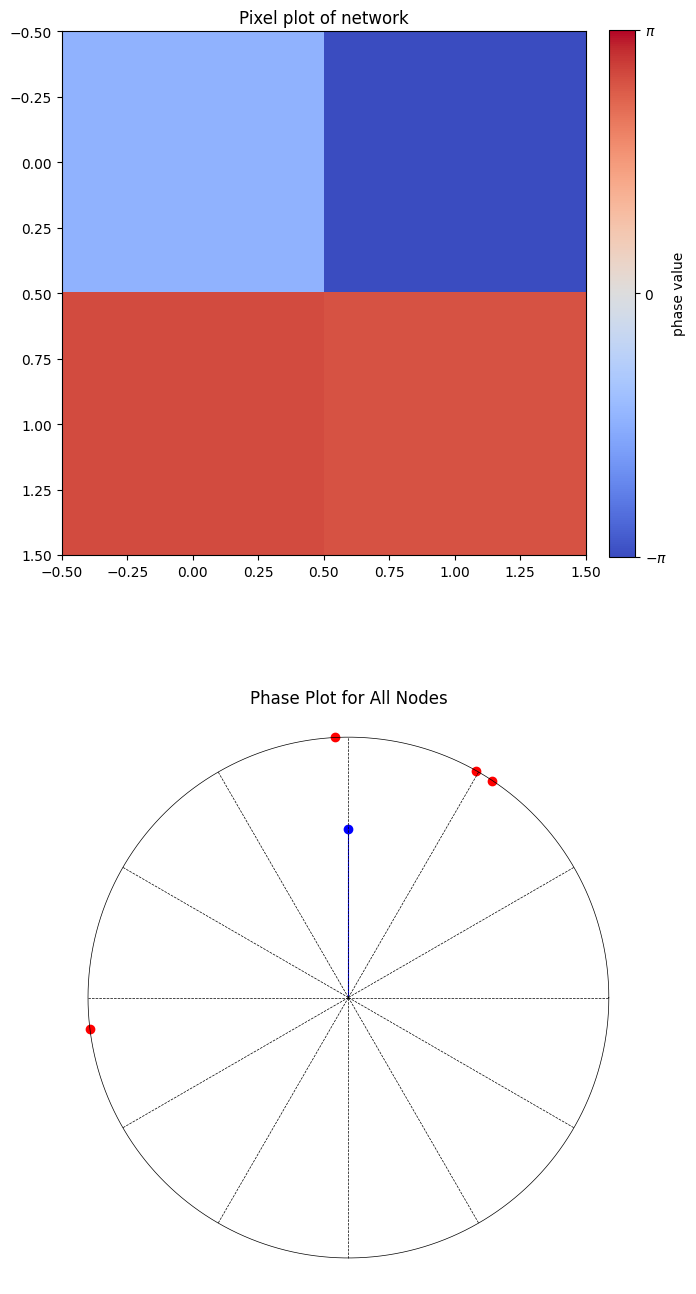

In [136]:
fig = plt.figure(figsize=(8,8))
graph_weighted_plot(G)
plt.show()

fig, axs = plt.subplots(2, 1, figsize=(7, 14))
graph_pixel_plot(axs[0], G, g_len, g_wid)
draw_phase_correlation(axs[1], G, rotate=True)
plt.tight_layout()
plt.show()

differential equations and integration

#

In [137]:
T = 10.0  # Total time
dt = 0.01  # Time step
times = np.arange(0, T+dt, dt)
thetas = integrate_graph(G,times)


plotting result

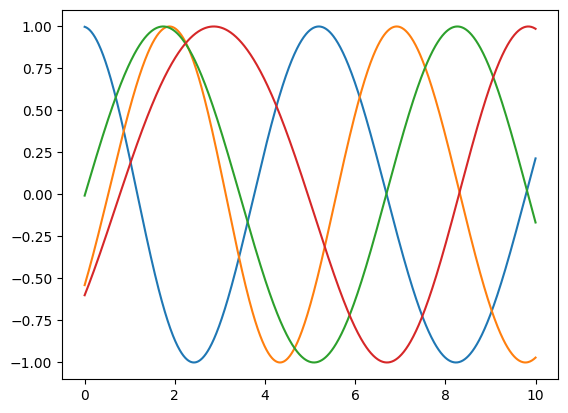

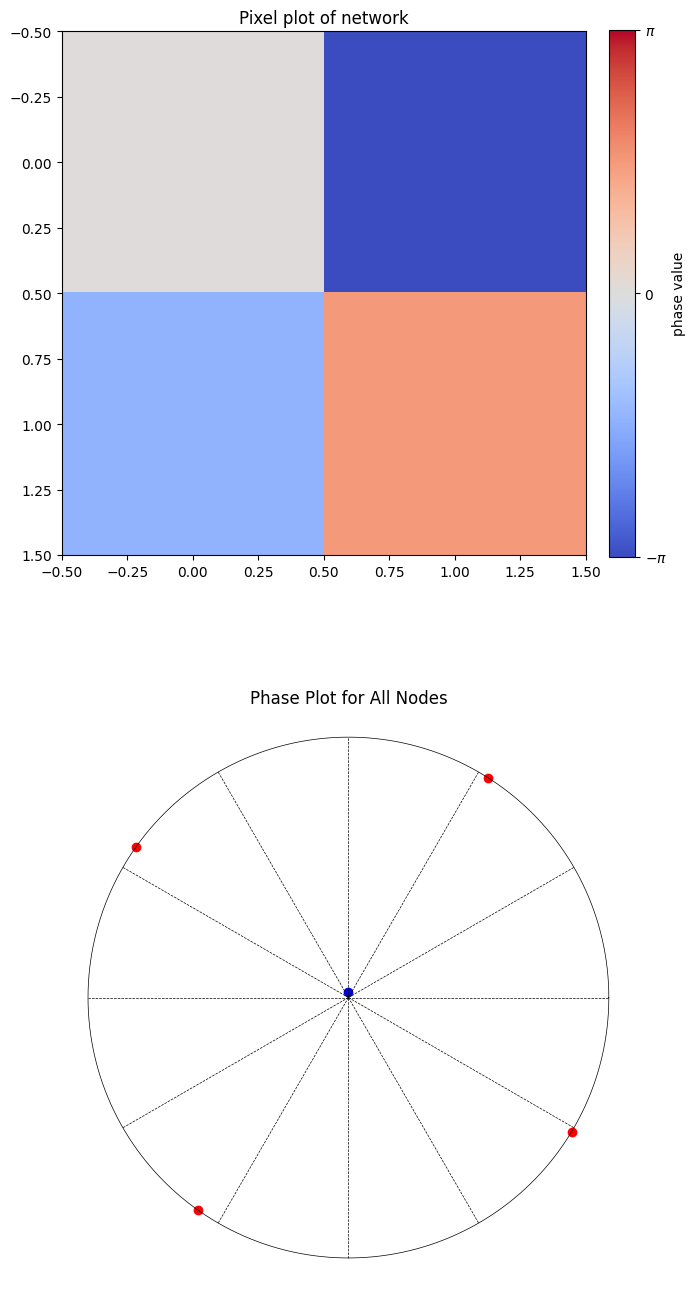

In [141]:
plt.plot(times,np.sin(thetas))
plt.show()

new_G = update_graph_nodes(G,thetas[-1])


fig, axs = plt.subplots(2, 1, figsize=(7, 14))
graph_pixel_plot(axs[0], new_G, g_len, g_wid)
draw_phase_correlation(axs[1], new_G, rotate=True)
plt.tight_layout()
plt.show()

# Experiments

1) convergence of larger network in relation to positive coupling and frequency variations

In [279]:
network = nx.Graph()
g_len = 6
g_wid = 6

nx.Graph.add_neighboring_nodes(network, g_len, g_wid)

#making dictionary of weights
#for practical reasons weights are multiplied by N (cancelling normalization) to better observe changes in globally defined values
weight_list = [np.random.uniform(4., 8.) for _ in network.edges]
weight_dict = {edge: weight for edge, weight in zip(network.edges, weight_list)}

phase_list = [np.random.uniform(0., 2*np.pi) for _ in network.nodes]
phase_dict = {node: phase for node, phase in zip(network.nodes, phase_list)}

frequency_list = [ 1 + np.random.normal(1., 0.003) for _ in network.nodes]
frequency_dict = {node: freq for node, freq in zip(network.nodes, frequency_list)}

nx.set_edge_attributes(network,weight_dict,"weight")
nx.set_node_attributes(network,phase_dict,"phase")
nx.set_node_attributes(network,frequency_dict,"frequency")


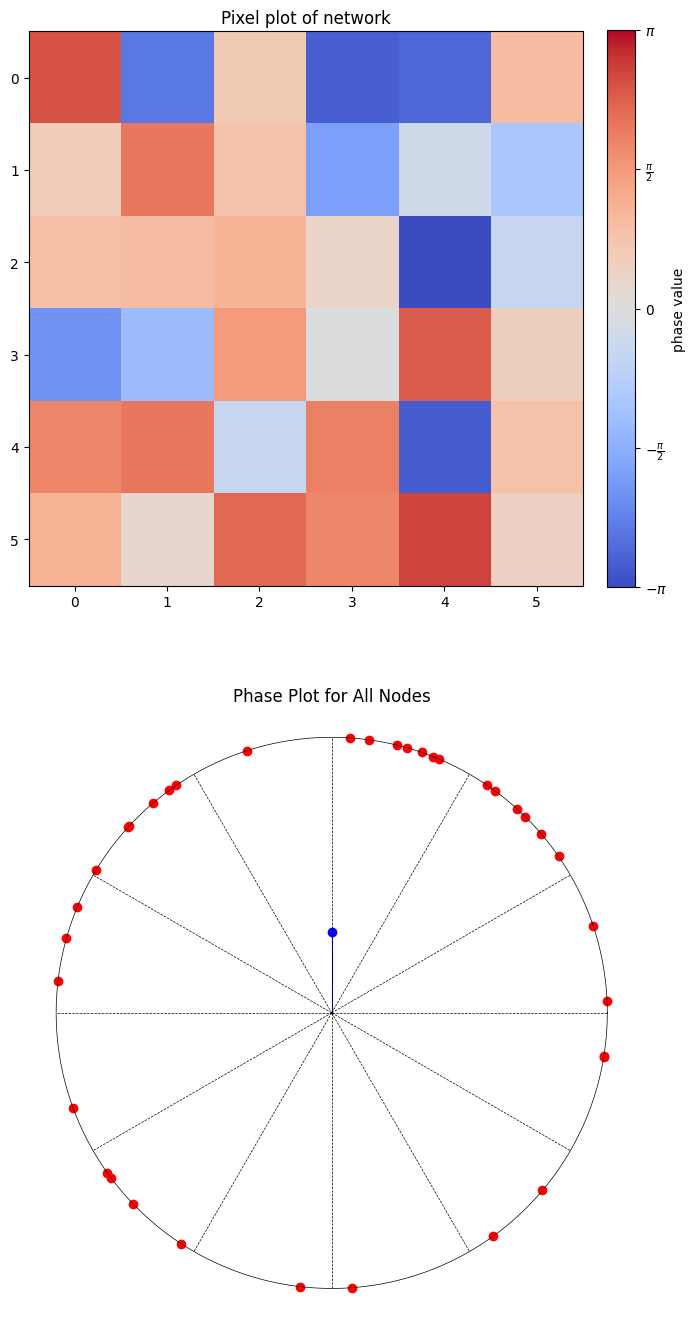

In [280]:
fig, axs = plt.subplots(2, 1, figsize=(7, 14))
graph_pixel_plot(axs[0], network, g_len, g_wid)
draw_phase_correlation(axs[1], network, rotate=True)
plt.tight_layout()
plt.show()

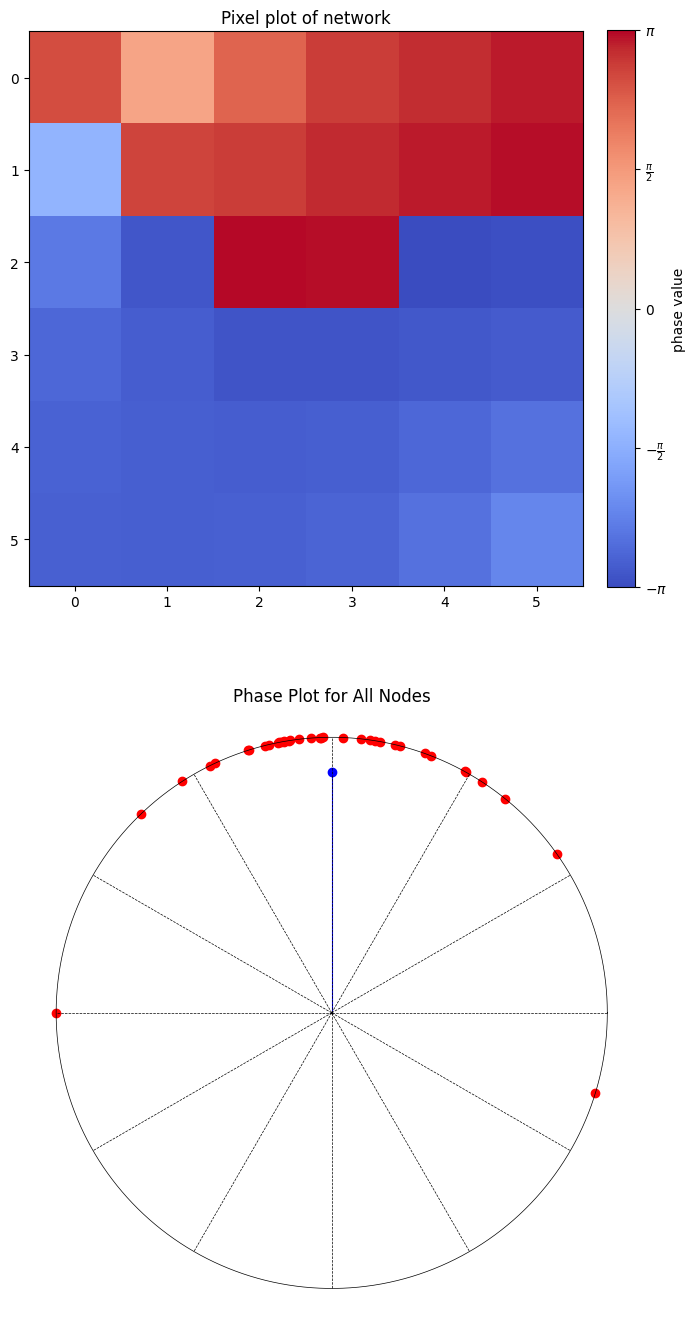

In [291]:
T = 2000.0  # Total time
dt = 0.01  # Time step
times = np.arange(0, T+dt, dt)


independent_nodes = [(0,0),(0,1),(1,0), (5,5)]
thetas, infodict = integrate_graph(network, times, independent_nodes=independent_nodes, full_output = 1)
#infodict only if output=1

new_network = update_graph_nodes(network,thetas[-1])

fig, axs = plt.subplots(2, 1, figsize=(7, 14))
graph_pixel_plot(axs[0], new_network, g_len, g_wid)
draw_phase_correlation(axs[1], new_network, rotate=True)
plt.tight_layout()
plt.show()

#żeby coupled oscillators dobrze działało - to powinien być tylko zestaw indeksów do theta, inaczej wszystko jest traktowane jak stała faza... byłem taki ślepy xd  

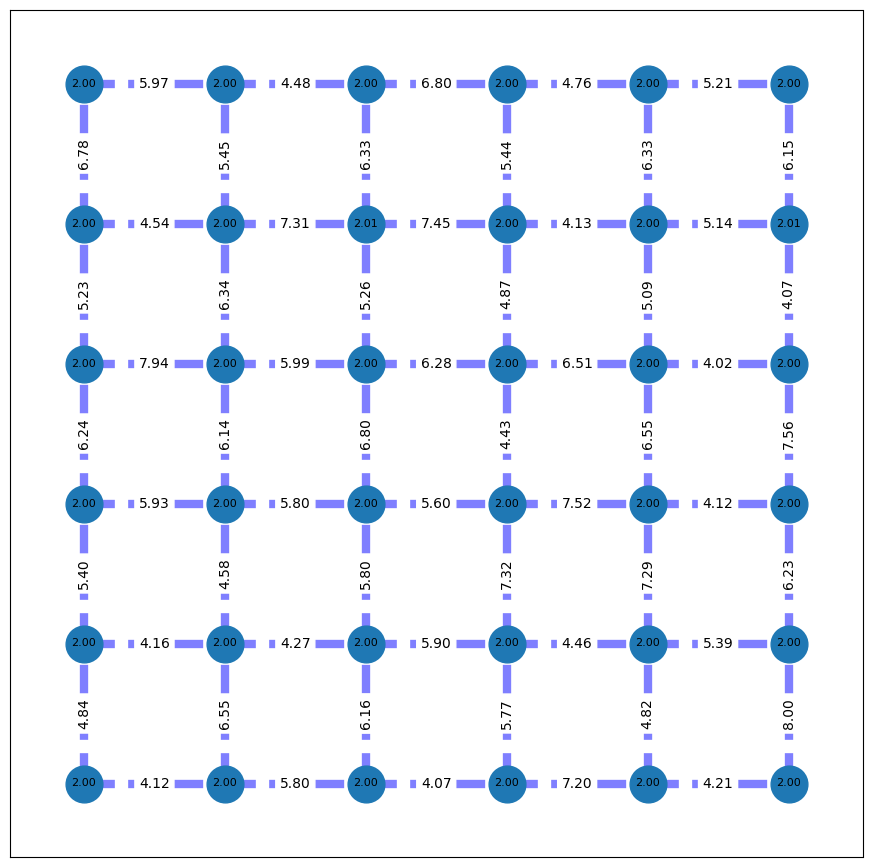

In [283]:
fig, ax = plt.subplots(figsize=(11,11))
graph_weighted_plot(ax,new_network)
plt.show()

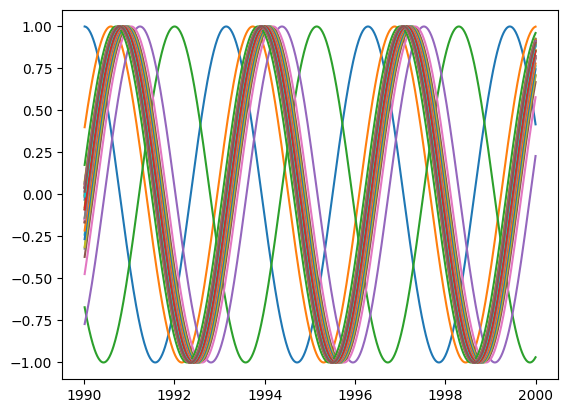

In [284]:
plt.plot(times[-1000:], np.sin(thetas[-1000:]))
plt.show()

In [287]:
T = 2000.0  # Total time
dt = 0.01  # Time step
times = np.arange(0, T+dt, dt)

independent_nodes = [(0,0),(0,1),(1,0)]
generate_evolution_and_animation(network,times,60,fps=6, independent_nodes=independent_nodes)

/tmp/ipykernel_184298/2212799516.py:239: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(image_file)


Video saved as animation.gif


# Notes and conclusions

- Defects or clusters occur because of slight differences between frequencies (3% difference influences the system drastically)

- Introducing  negative weights prevents network from stabilizing (but still mean phase difference may contain useful information)

- Whether a system is completely chaotic or has one or several stable states can probably be controlled, although using random network generation I haven't observed multiple stable states yet.

# XOR function and training

In [2]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

In [9]:
features = np.array([
    [0,0],
    [1,0],
    [0,1],
    [1,1]
])
labels = np.array([0,1,1,0])

features_converted = np.array([
    [-np.pi,-np.pi],
    [np.pi,-np.pi],
    [-np.pi,np.pi],
    [np.pi,np.pi]
])
labels_converted = np.array([-np.pi,np.pi,np.pi,-np.pi])

i = 3


N = 5
T = 100.0  # Total time
dt = 0.01  # Time step
times = np.arange(0, T+dt, dt)


theta0 = np.random.uniform(0, 2*np.pi, N)
omega = np.array([np.random.normal(1,0.0003) for i in range(N)])

#1,2 - input
#3,4 - hidden
#5 - output

lowest_rand_value = -1
highest_rand_value = 1

#coupling values 
#not counting biases
K = [[None] * 5 for _ in range(5)]

def assign_symmetric(i, j, value):
    K[i-1][j-1] = value
    K[j-1][i-1] = value

for num in range(5):
    assign_symmetric(num,num,0.)

assign_symmetric(1, 3, np.random.uniform(lowest_rand_value, highest_rand_value))
assign_symmetric(1, 2, np.random.uniform(lowest_rand_value, highest_rand_value))
assign_symmetric(1, 5, np.random.uniform(lowest_rand_value, highest_rand_value))
assign_symmetric(1, 4, np.random.uniform(lowest_rand_value, highest_rand_value))
assign_symmetric(2, 1, np.random.uniform(lowest_rand_value, highest_rand_value)) 
assign_symmetric(2, 5, np.random.uniform(lowest_rand_value, highest_rand_value))
assign_symmetric(2, 4, np.random.uniform(lowest_rand_value, highest_rand_value))
assign_symmetric(2, 3, np.random.uniform(lowest_rand_value, highest_rand_value))
assign_symmetric(4, 3, np.random.uniform(lowest_rand_value, highest_rand_value))
assign_symmetric(4, 5, np.random.uniform(lowest_rand_value, highest_rand_value))
assign_symmetric(5, 3, np.random.uniform(lowest_rand_value, highest_rand_value))

K = np.array(K)

coupling_indeces = np.array([
    [0,1,2,3,4],
    [0,1,2,3,4],
    [0,1,2,3,4],
    [0,1,2,3,4],
    [0,1,2,3,4]
])



In [10]:

def coupled_oscillators(theta, t, omega, K, N, coupling_indeces):
    coupled = theta[coupling_indeces]
    dtheta_dt = omega - (1/N) * np.sum(K * np.sin(coupled-theta), axis=1)
    return dtheta_dt

theta0 = np.random.uniform(-np.pi, np.pi, N)
#omega = np.array([np.random.normal(1,0.0003) for i in range(N)])
omega = np.array([1 for i in range(N)])

index = 3
theta0[0] = features_converted[index][0]
K[0] = np.array([0,0,0,0,0])

theta0[1] = features_converted[index][1]
coupling_indeces[1] = [1]
K[1] = np.array([0,0,0,0,0])

K_prev = np.copy(K)



K = np.copy(K_prev)
beta = 0.1
learning_rate = 0.01

#step forward
thetas_forward = odeint(coupled_oscillators, theta0, times, args=(omega, K, N, coupling_indeces))

theta0 = thetas_forward[-1,:]
#equilibrium propagation values
theta0[4] = (1-beta)*theta0[4] + beta * (labels_converted[index])
K_prev = np.copy(K)
K[4] = np.array([0,0,0,0,0])
thetas_nudge = odeint(coupled_oscillators, theta0, times, args=(omega, K, N, coupling_indeces))

 



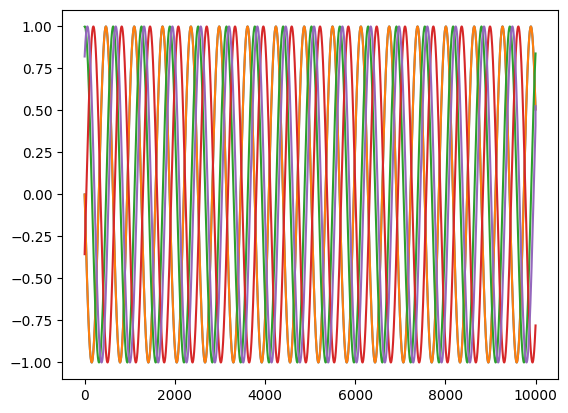

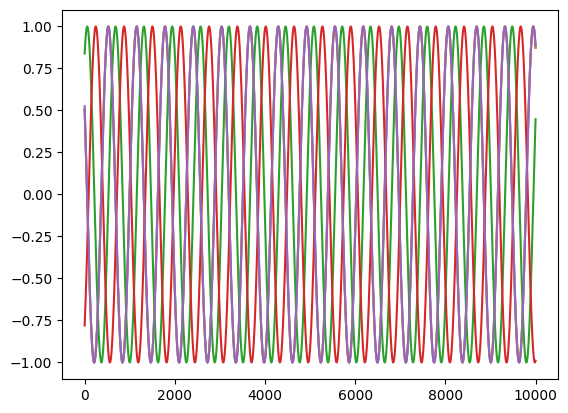

In [11]:
plt.plot(np.sin(thetas_forward))
plt.show()

plt.plot(np.sin(thetas_nudge))
plt.show()

# Learning XOR Network

In [83]:
def initialize_network(size, independent_nodes=None):
    network = nx.complete_graph(size)

    weight_list = [np.random.normal(loc=0, scale=3) for _ in network.edges]
    weight_dict = {edge: weight for edge, weight in zip(network.edges, weight_list)}

    biast_list = [np.random.uniform(-0.5, 0.5) for _ in network.nodes]
    bias_dict = {node: bias for node, bias in zip(network.nodes, biast_list)}

    bias_phase_list = [np.random.uniform(-np.pi, np.pi) for _ in network.nodes]
    bias_phase_dict = {node: bias_phase for node, bias_phase in zip(network.nodes, bias_phase_list)}

    if independent_nodes is not None:
        for node in independent_nodes:
            bias_dict[node] = 0  # Set bias to 0 for independent nodes

    phase_list = [np.random.uniform(-np.pi, np.pi) for _ in network.nodes]
    phase_dict = {node: phase for node, phase in zip(network.nodes, phase_list)}

    #frequency_list = [ 1 + np.random.normal(1., 0.00003) for _ in network.nodes]
    frequency_list = [ 1  for _ in network.nodes]
    frequency_dict = {node: freq for node, freq in zip(network.nodes, frequency_list)}

    nx.set_edge_attributes(network,weight_dict,"weight")
    nx.set_node_attributes(network,bias_dict,"bias")
    nx.set_node_attributes(network,bias_phase_dict,"bias_phase")
    nx.set_node_attributes(network,phase_dict,"phase")
    nx.set_node_attributes(network,frequency_dict,"frequency")
    return network
    
def randomize_node_phases(graph):
    phase_list = [np.random.uniform(-np.pi, np.pi) for _ in graph.nodes]
    phase_dict = {node: phase for node, phase in zip(graph.nodes, phase_list)}
    nx.set_node_attributes(graph,phase_dict,"phase")
    return graph

def update_weights_simple(graph, learning_rate, gradient):
    for i, (u, v, data) in enumerate(graph.edges(data=True)):      
        data['weight'] -= learning_rate * gradient[i]

def update_biases_simple(graph, learning_rate, bias_gradient, bias_phase_gradient):
    for i, (n, data) in enumerate(graph.nodes(data=True)):
        data['bias'] -= learning_rate * bias_gradient[i]
        data['bias_phase'] -= learning_rate * bias_phase_gradient[i]

def give_input(graph, input_nodes, input_values):
    for i, node in enumerate(input_nodes):
        graph.nodes[node]["phase"] = input_values[i]


#this might not be the best way to nudge, size of change is largely dependent on how far from target we stand.
def nudge_output(graph, output_nodes, target, nudge_size):
    for i, node in enumerate(output_nodes):
        current_phase = graph.nodes[node]['phase']
        new_phase = (1-nudge_size)*current_phase + nudge_size * (target[i])
        graph.nodes[node]['phase'] = new_phase

In [162]:
network = initialize_network(5, independent_nodes=[0,1])
T = 10.0  # Total time (it could be as low as 10 or less)
dt = 0.01  # Time step
times = np.arange(0, T+dt, dt)

gradient = 0

def mean_distance(output, target):
    dist = []
    for number, o in enumerate(output):
        dist.append(1-np.cos(o-target[number]))
    return dist

batch_size = 4
input_nodes = [0,1]
output_nodes = [4]
random_init_times = 4



#edge labels
edges = [edge for edge in network.edges(data=False)]
net_nodes = [node for node in network.nodes(data=False)] 
len_edges = len(edges)

features = np.array([
    [0,0],
    [1,0],
    [0,1],
    [1,1]
])

labels = np.array([0,1,1,0])

#seems worse than the second one
features_converted = np.array([
    [-np.pi,-np.pi],
    [np.pi,-np.pi],
    [-np.pi,np.pi],
    [np.pi,np.pi]
])/2
features_converted += np.random.randn(*features_converted.shape) * 1e-10 #small addition due to technical reasons behind implementation
labels_converted = np.array([[-np.pi],[np.pi],[np.pi],[-np.pi]])/2
labels_converted += np.random.randn(*labels_converted.shape) * 1e-10

features_converted = np.array([
    [0,0],
    [np.pi,0],
    [0,np.pi],
    [np.pi,np.pi]
])/2
features_converted += np.random.randn(*features_converted.shape) * 1e-10
labels_converted = np.array([[0],[np.pi],[np.pi],[0]])/2
labels_converted += np.random.randn(*labels_converted.shape) * 1e-10


distances = []
all_outputs = []

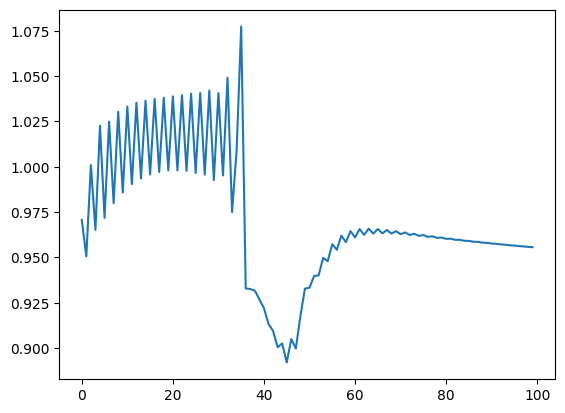

In [163]:
learning_rate = 0.01 # arbitrary learning step (has to be very carefully selected, especially for ONN)
nudge_step = 0.00001 # small to properly compute gradient
number_of_epochs = 100

inv_nudge_step = 1/nudge_step
inv_batch_size = 1/batch_size
inv_random_init_times = 1/random_init_times

for i in range(number_of_epochs):

    #does this work on original network?
    #I have to check each function
    outputs = []
    distance = 0
    gradient = 0
    bias_gradient = 0
    bias_phase_gradient = 0
    for j, feature in enumerate(features_converted):
        #randomize_node_phases(network)
        
        free_energy_per_weight = np.empty(len_edges)
        free_energy_per_bias = np.empty(len_edges)
        free_energy_per_bias_phase = np.empty(len_edges)

        nudge_energy_per_weight = np.empty(len_edges)
        nudge_energy_per_bias = np.empty(len_edges)
        nudge_energy_per_bias_phase = np.empty(len_edges)

        label = labels_converted[j]

        independent_nodes = input_nodes
        give_input(network, input_nodes, feature)
        
        thetas = integrate_graph(network, times, independent_nodes=independent_nodes, full_output = 0)
        
        network = update_graph_nodes(network,thetas[-1])

        for i, (n1, n2) in enumerate(edges):
            p1 = network.nodes(data=True)[n1]["phase"]
            p2 = network.nodes(data=True)[n2]["phase"]
            free_energy_per_weight[i] = - np.cos(p1-p2)

        for i, n in enumerate(net_nodes):
            p = network.nodes(data=True)[n]["phase"]
            pe = network.nodes(data=True)[n]["bias_phase"]
            h = network.nodes(data=True)[n]["bias"]
            free_energy_per_bias[i] = - np.cos(p-pe)
            free_energy_per_bias_phase[i] = - h*np.sin(p-pe)

        output = [network.nodes(data=True)[out]["phase"] for out in output_nodes]
        outputs.append(output)
        #make output independent and nudge it towards target value linearly
        independent_nodes = input_nodes + output_nodes
        nudge_output(network, output_nodes, label, nudge_step)

        thetas_back = integrate_graph(network, times, independent_nodes=independent_nodes, full_output = 0)
        network = update_graph_nodes(network,thetas_back[-1])

        #weight energy calculation
        for i, (n1, n2) in enumerate(edges):
            p1 = network.nodes(data=True)[n1]["phase"]
            p2 = network.nodes(data=True)[n2]["phase"]
            nudge_energy_per_weight[i] = - np.cos(p1-p2)

        #bias energy calculation
        for i, n in enumerate(net_nodes):
            p = network.nodes(data=True)[n]["phase"]
            pe = network.nodes(data=True)[n]["bias_phase"]
            h = network.nodes(data=True)[n]["bias"]
            nudge_energy_per_bias[i] = - np.cos(p-pe)
            nudge_energy_per_bias_phase[i] = - h*np.sin(p-pe)

        #training:
        
        gradient -= (
            learning_rate * inv_nudge_step * inv_batch_size *  inv_random_init_times *
            (nudge_energy_per_weight - free_energy_per_weight)
        )
        bias_gradient -= (
            learning_rate * inv_nudge_step * inv_batch_size *  inv_random_init_times *
            (nudge_energy_per_bias - free_energy_per_bias)
        )
        bias_phase_gradient -= (
            learning_rate * inv_nudge_step * inv_batch_size *  inv_random_init_times *
            (nudge_energy_per_bias_phase - free_energy_per_bias_phase)
        )


        # should save some RAM space, probably garbage collector does it already automatically
        del thetas
        del thetas_back
    
    for label_number,  o in enumerate(outputs):
        distance += mean_distance(o, labels_converted[label_number])[0]
    all_outputs.append(outputs)
    distances.append(distance/batch_size)
    
    gradient /= batch_size
    bias_gradient /= batch_size
    bias_phase_gradient /= batch_size
    update_weights_simple(network, learning_rate, gradient)
    update_biases_simple(network, learning_rate, bias_gradient, bias_phase_gradient)
    

plt.plot(distances)

input at the end: -9.988670273393283e-11	 5.6883385049920444e-11
input:	 -9.988670273393283e-11 	 5.6883385049920444e-11 
output:	 -0.26255964866994175 	modulo:	 0.26255964866994175 
label:	 [8.7507879e-11]
mean distance:	 [0.034271222858200834]


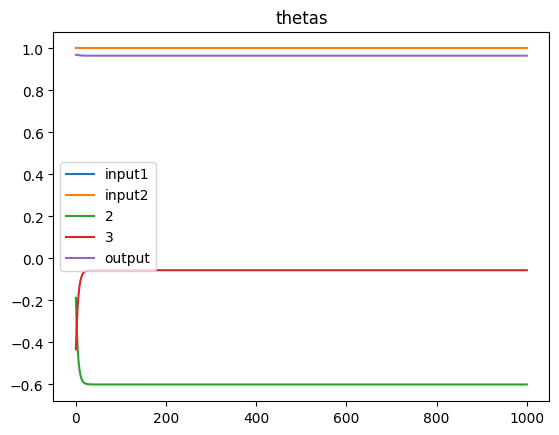

input at the end: 1.5707963268330598	 -1.5294205701869556e-10
input:	 1.5707963268330598 	 -1.5294205701869556e-10 
output:	 -0.20833439233610568 	modulo:	 0.20833439233610568 
label:	 [1.57079633]
mean distance:	 [1.2068305955947942]


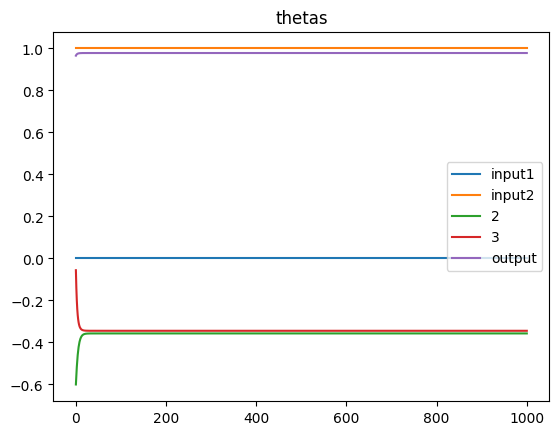

input at the end: 1.0400114320153276e-10	 1.5707963268283869
input:	 1.0400114320153276e-10 	 1.5707963268283869 
output:	 -0.2807430418764591 	modulo:	 0.2807430418764591 
label:	 [1.57079633]
mean distance:	 [1.2770696767351593]


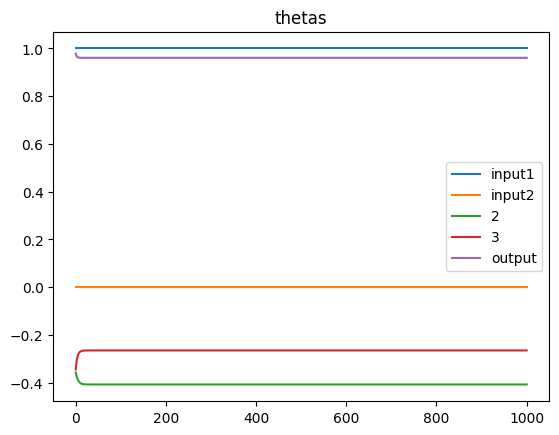

input at the end: 1.5707963268070027	 1.5707963267674379
input:	 1.5707963268070027 	 1.5707963267674379 
output:	 -0.23600871685458763 	modulo:	 0.23600871685458763 
label:	 [1.57649962e-10]
mean distance:	 [0.027721026079689737]


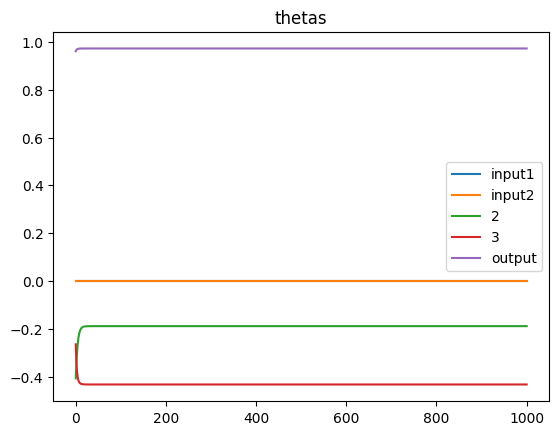

0.636473130316961


In [143]:
temp_dist = []
for i, feature in enumerate(features_converted):
    #randomize_node_phases(network)
    label = labels_converted[i]
    independent_nodes = [0,1]
    give_input(network, input_nodes, feature)
    thetas = integrate_graph(network, times, independent_nodes=independent_nodes, full_output = 0)
    network = update_graph_nodes(network,thetas[-1])
    print(f"input at the end: {thetas[-1][0]}\t {thetas[-1][1]}")
    print("input:\t",thetas[0][0],"\t", thetas[0][1],"\noutput:\t", thetas[-1][4], "\tmodulo:\t",np.mod(np.abs(thetas[-1][4]),np.pi),"\nlabel:\t",label)
    print("mean distance:\t", mean_distance([thetas[-1][4]], label))
    temp_dist.append(mean_distance([thetas[-1][4]], label))
    plt.plot(np.cos(thetas))
    plt.title("thetas")
    plt.legend(["input1","input2","2","3","output"])
    plt.show()
print(np.mean(temp_dist))


In [16]:
network.nodes(data=True)


NodeDataView({0: {'bias': 0.0, 'bias_phase': 0.8876736525492577, 'phase': 1.5707963267948966, 'frequency': 1}, 1: {'bias': 0.0, 'bias_phase': -2.6671046121313, 'phase': 1.5707963268029466, 'frequency': 1}, 2: {'bias': 4.138812279951796, 'bias_phase': -4.567529000539278, 'phase': -1.5707963267882192, 'frequency': 1}, 3: {'bias': 3.65680118079701, 'bias_phase': 5.109290449307679, 'phase': 4.712388980392565, 'frequency': 1}, 4: {'bias': -0.3318466574514217, 'bias_phase': -2.1173549861157013, 'phase': -1.570796326786925, 'frequency': 1}, 5: {'bias': -1.2176201911901965, 'bias_phase': 1.2020621893712349, 'phase': -1.5707963267880372, 'frequency': 1}, 6: {'bias': -4.4636969636404125, 'bias_phase': -2.527825922795933, 'phase': 1.5707963268048504, 'frequency': 1}, 7: {'bias': 0.1528171317930558, 'bias_phase': 2.5093564765113276, 'phase': -1.5707963267879264, 'frequency': 1}})

- I can witness weird behavior of second input - I don't know yet what is the couse.
- reversing gradient has profound implications - as there seems to be well defined maximum (outputs oposite to the solutions) and problematic minimum
- repairing input dynamics will be crucial

# Test area
*debugging mainly*

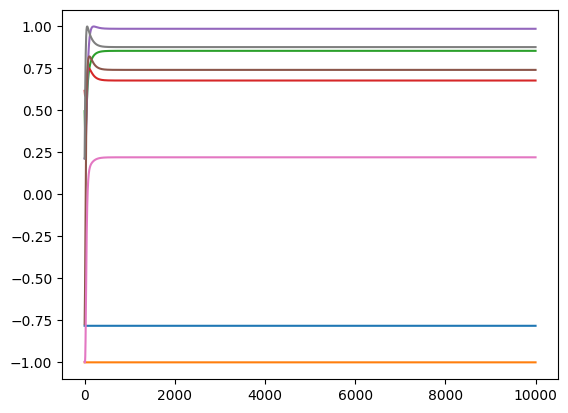

In [59]:
randomize_node_phases(network)
graph = network
independent_nodes=[0,1]

def graph_kuramoto_oscillators(theta, t, omega, K, h, psi, N, coupled_theta):
    dtheta_dt = np.zeros_like(theta)
    for i in range(N):
        if -1 in coupled_theta[i]:  # Handle independent nodes
            dtheta_dt[i] = omega[i]
        else:
            coupled_values = theta[coupled_theta[i]]
            sin_diffs = np.sin(theta[i] - coupled_values)
            sin_external = np.sin(theta[i] - psi[i])
            dtheta_dt[i] = np.sum((K[i] * sin_diffs) - (h[i]*sin_external)) / N
    return dtheta_dt

theta0 = np.array([node[1]['phase'] for node in graph.nodes(data=True)])
T = 100.0  # Total time (it could be as low as 10 or less)
dt = 0.01  # Time step
times = np.arange(0, T+dt, dt)
omega = np.array([node[1]['frequency'] for node in graph.nodes(data=True)])
h = np.array([node[1]['bias'] for node in graph.nodes(data=True)])
psi = np.array([node[1]['bias_phase'] for node in graph.nodes(data=True)])
K = [[edge[2] for edge in graph.edges(node, data="weight")] for node in graph.nodes]
N = graph.number_of_nodes()
max_length = max([len(sublist) for sublist in K])
K = np.zeros((N, max_length))
coupled_theta = np.zeros((N, max_length)).astype(int)
independent_indices = [np.where(theta0 == graph.nodes[node]['phase'])[0][0] for node in independent_nodes]
for i, node in enumerate(graph.nodes()):
    for j, neighbor in enumerate(graph.neighbors(node)):
        K[i, j] = graph[node][neighbor]['weight']
        neighbor_index = int(np.where(theta0==graph.nodes[neighbor]['phase'])[0][0])
        coupled_theta[i, j] = neighbor_index if i not in independent_indices else i  # this should return coupling to self which indicates no coupling at all
    

#graph_kuramoto_oscillators(theta, t, omega, K, h, psi, N, coupled_theta)

thetas, output = odeint(graph_kuramoto_oscillators, theta0, times, args=(omega, K, h, psi, N, coupled_theta), full_output=1)


plt.plot(np.cos(thetas))